# Assemble Monocam Images
=============================================

- Creation : Tuesday 2016 June 14th
- Author Sylvie Dagoret-Campagne 
- affiliation : LAL/IN2P3/CNRS

Put together the images from the different amplifiers


## 1) Import package

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [129]:
from scipy import stats  
import os
from datetime import datetime, timedelta

In [130]:
import libMonocamBaseImages           # my tool library written to do that CCD reduction

In [131]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-06-14 13:48:36.532218
fits date format for the analysis :  2016-06-14T13:48:36


## 2) Configuration of the detector

In [132]:
NB_OF_CHAN_AMPL=16    # 16 images in each of the fits file

## 3) Configuration of the input file

- HD158485_grat_science.fits
- HD159222_grat_science.fits
- HD163466_grat_science.fits


In [133]:
path='.'
object_name='HD158485_grat'
basefilename='HD158485_grat_science.fits' # check master bias
filename=os.path.join(path,basefilename)
outputfigfilename='ScienceImageAssemblerInput_img.pdf'
outputfigfilename2='ReorderedImage_'+object_name+'_img.pdf'
outputfigfilename3='SingleImage_'+object_name+'_img.pdf'

In [134]:
#object_name='HD158485_grat'
object_name='HD159222_grat'
#object_name='HD163466_grat'

In [135]:
path='.'
basefilename=object_name +'_science.fits' # check master bias
filename=os.path.join(path,basefilename)
outputfigfilename='ScienceImageAssemblerInput_img.pdf'
outputfigfilename2='ReorderedImage_'+object_name+'_img.pdf'
outputfigfilename3='SingleImage_'+object_name+'_img.pdf'

In [136]:
#path='.'
#object_name='HD163466_grat'
#basefilename='HD163466_grat_science.fits' # check master bias
#filename=os.path.join(path,basefilename)
#outputfigfilename='ScienceImageAssemblerInput_img.pdf'
#outputfigfilename2='ReorderedImage_'+object_name+'_img.pdf'
#outputfigfilename3='SingleImage_'+object_name+'_img.pdf'

## 4) Read the images

In [137]:
allimages = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = ccdproc.CCDData.read(filename, hdu=chan,unit="adu") 
    allimages.append(ccd_chan)

## 5) Shows the images

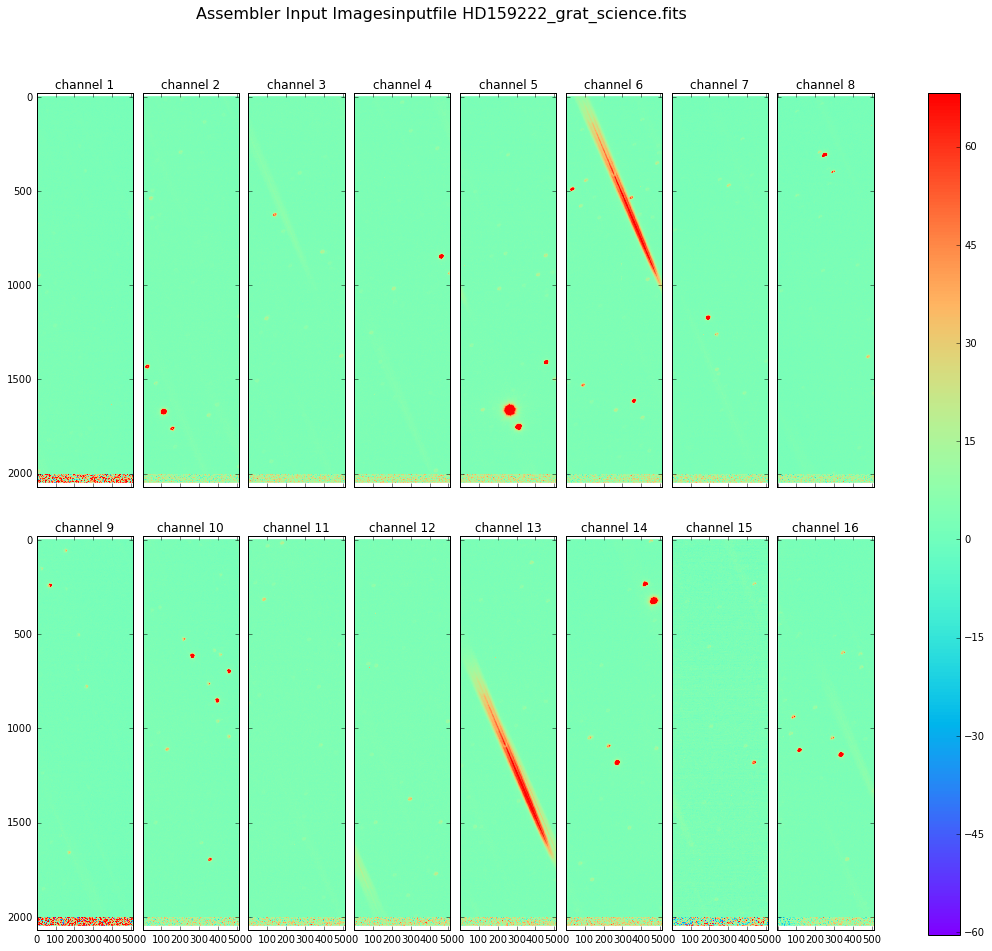

In [138]:
libMonocamBaseImages.ShowImagesSet(allimages,'Assembler Input Images',basefilename,outputfigfilename,nbsig=3)

## 6) Reorder the image

In [139]:
Channel_mapping = [8,7,6,5,4,3,2,1,9,10,11,12,13,14,15,16]
Channel_flipupdo = [False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True]

In [140]:
def ShowCorrectImagesSet(image_list,mapping_chan,flip_chan,obj,figname):
    '''
    Shows the whole set of CCD images
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
     
    NX=8 # number of images along the horizontal axis
    NY=2 # number of images along the vertical axis
    MIN=0
    MAX=40.0
    f, axarr = plt.subplots(NY,NX,sharex='col', sharey='row',figsize=(15,15)) # figure organisation
    
    f.subplots_adjust(hspace=0.01,wspace=0.01)

    for index in range(NB_OF_CHAN_AMPL):  
        ix=index%8
        iy=index/8
        goodindex=mapping_chan[index]-1
        if not flip_chan[index]:
            image_data = image_list[goodindex].data[0:2000,:]
        else:
            image_data = np.flipud(np.fliplr(image_list[goodindex].data[0:2000,:]))
        
        im=axarr[iy,ix].imshow(image_data,vmin=MIN,vmax=MAX)  # plot the image
        if ix==0 and iy==0:
            im0=im
        plottitle='channel {}'.format(goodindex+1)
        axarr[iy,ix].set_title(plottitle)
    
    title='Reordered Image for object '+obj
    cax = f.add_axes([0.95, 0.12, 0.03, 0.78]) # [left,bottom,width,height]    
    f.colorbar(im0, cax=cax)
   
    plt.suptitle(title,size=16)
    plt.savefig(figname, bbox_inches='tight')

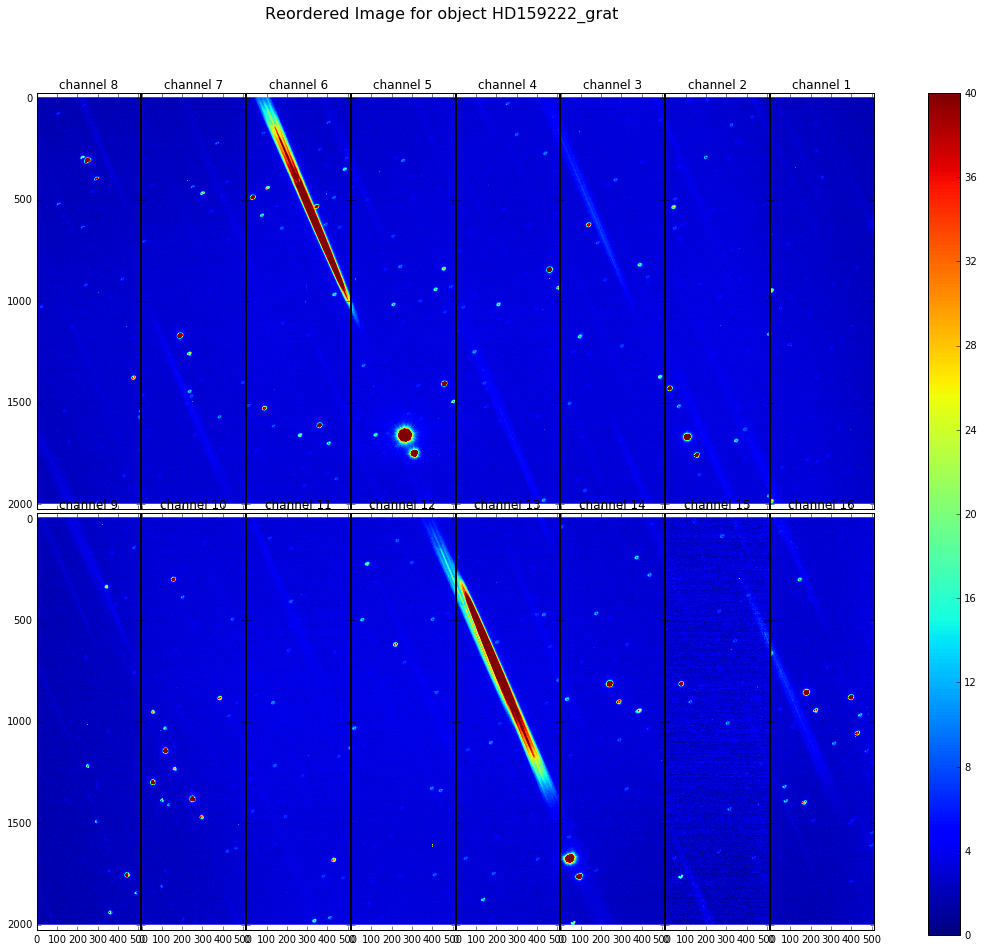

In [141]:
ShowCorrectImagesSet(allimages,Channel_mapping,Channel_flipupdo,object_name,outputfigfilename2)

## Make a single array

In [142]:
def MakeSingleImage(image_list,mapping_chan,flip_chan):
    '''
     
    '''
         

    for index in range(NB_OF_CHAN_AMPL):  
       
        goodindex=mapping_chan[index]-1
        if not flip_chan[index]:
            image_data = image_list[goodindex].data[0:2000,:]
        else:
            image_data = np.flipud(np.fliplr(image_list[goodindex].data[0:2000,:]))
            
        if index == 0:
            imageup =image_data
        elif index >=1 and index <=7:
            imageup = np.concatenate((imageup,image_data),axis=1)
        elif index ==8 :
            imagedo = image_data
        else:
            imagedo = np.concatenate((imagedo,image_data),axis=1)
            
    full_image=np.concatenate((imageup,imagedo),axis=0)
    return full_image
        
       

In [143]:
concatenatedimage=MakeSingleImage(allimages,Channel_mapping,Channel_flipupdo)

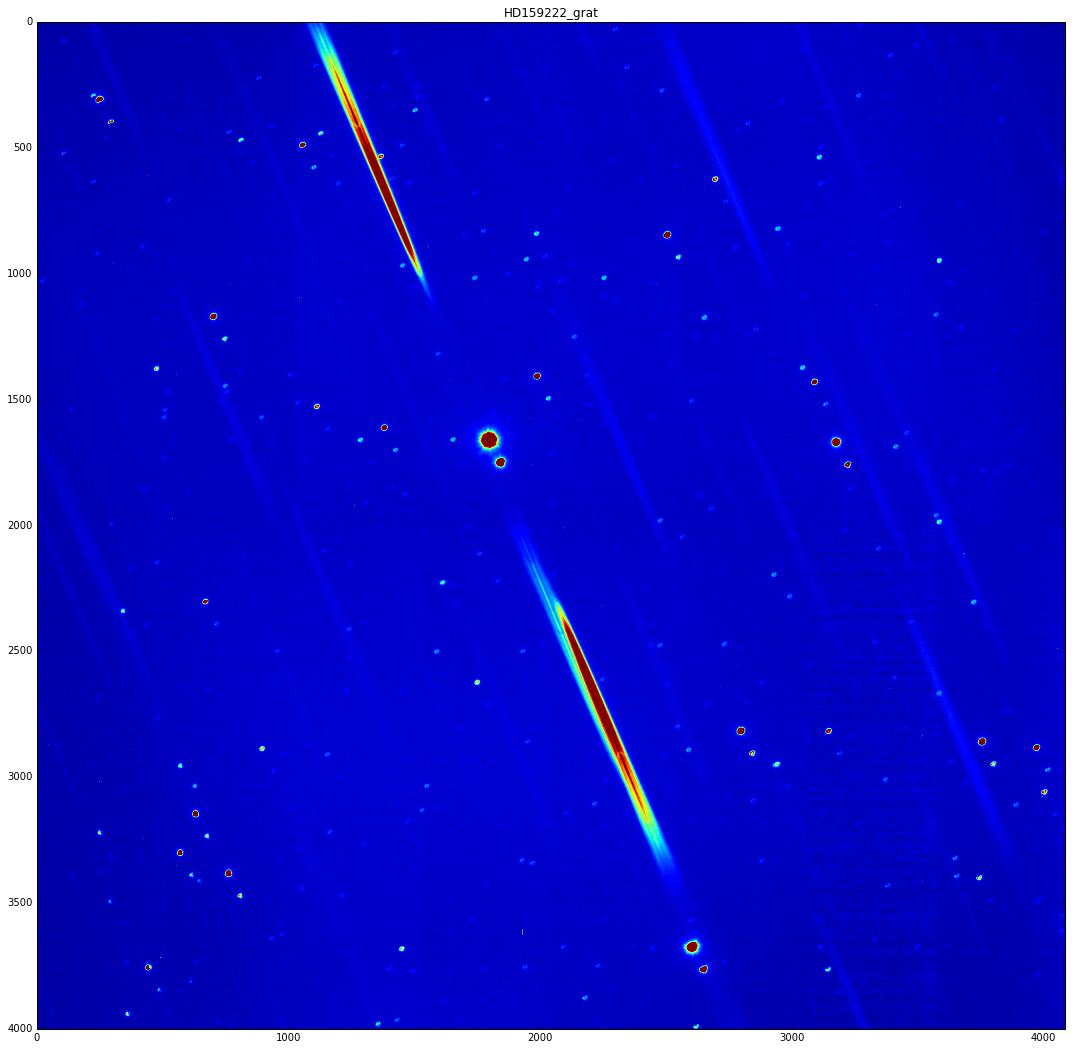

In [144]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(concatenatedimage,vmin=0,vmax=50.)
plt.title(object_name)
plt.tight_layout()
plt.savefig(outputfigfilename3)